In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/My Drive/ProyectoIA2/generative-spectral-datasets')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from models.main import make_encoder, make_generator, make_discriminator, spectralGAN
from models.utils import discriminator_loss, autoencoder_loss, spec2rgb
from models.metrics import PSNR, SSIM
from data import load_dataset
import scipy.io as sio
import matplotlib.pyplot as plt

input_shape = (512,512,31)

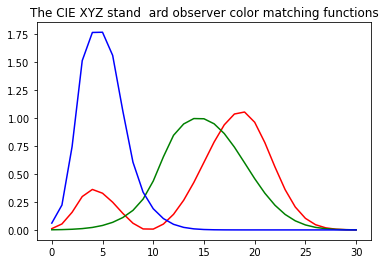

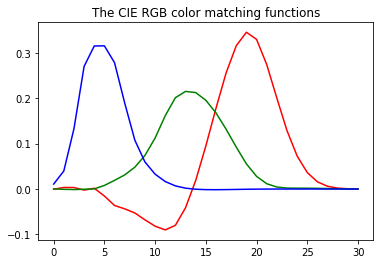

In [3]:
def g(x, alpha, mu, sigma1, sigma2):
  sigma = (x < mu)*sigma1 + ( x >= mu)*sigma2 
  return alpha*np.exp( (x-mu)**2 / (-2*(sigma**2) ) )

color_r = lambda x: g(x, 1.056, 5998, 379, 310)  +  g(x, 0.362, 4420, 160, 267) +  g(x, -0.065, 5011, 204, 262)
color_g = lambda x: g(x, 0.821, 5688, 469, 405)  +  g(x, 0.286, 5309, 163, 311)
color_b = lambda x: g(x, 1.217, 4370, 118, 360)  +  g(x, 0.681, 4590, 260, 138)

Phi = np.array([
    [ 0.41847, -0.15866, -0.082835],
    [-0.091169, 0.25243, 0.015708],
    [0.00092090, -0.0025498, 0.17860],             
]
)

eje_x = np.linspace(400, 720, 31)*10
CMF = np.array( [color_r(eje_x), color_g(eje_x), color_b(eje_x)] ).T

RGB = CMF@Phi.T

plt.title("The CIE XYZ stand  ard observer color matching functions")
plt.plot(CMF[:,0], c='r')
plt.plot(CMF[:,1], c='g')
plt.plot(CMF[:,2], c='b')

plt.show()

plt.title("The CIE RGB color matching functions")

plt.plot(RGB[:,0], c='r')
plt.plot(RGB[:,1], c='g')
plt.plot(RGB[:,2], c='b')

plt.show()

RGB = np.float32( RGB / np.sum(RGB, axis=0, keepdims=True) )

In [4]:
Phi.dtype

dtype('float64')

In [5]:
BATCH_SIZE = 1

train_params = dict(
    batch_size = BATCH_SIZE,
    shuffle = True,
    cache = True
)

test_params = dict(
    batch_size = BATCH_SIZE,
    cache = True
)

train_ds , test_ds = load_dataset( train_params = train_params, test_params = test_params)

minimo 0.0019596717
maximo 0.8741875


 tf.Tensor([0.00446798 0.00548323 0.01207517], shape=(3,), dtype=float32)


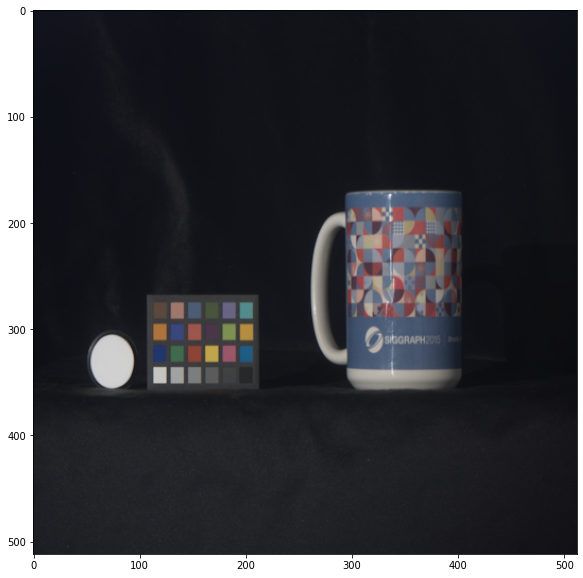

In [6]:
sample = next(iter(train_ds))
im = np.expand_dims(sample[0,...], axis = 0)

rgb = spec2rgb(im, RGB)
print( "minimo",np.min(rgb))
print( "maximo",np.max(rgb))

plt.figure(figsize=(10,10))
plt.imshow(np.power(rgb[0,:,:,:], 0.5))
print('\n\n',rgb[0, 0,0])



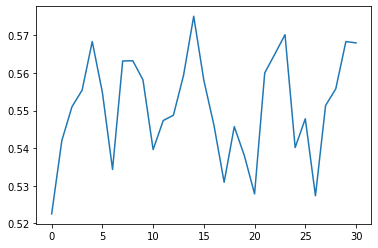

In [7]:

(m,n,la) = np.shape(im)[1:]
#m = np.shape(im)[1]
#n = np.shape(im)[2]
#la = np.shape(im)[3]

X = np.reshape(im, (1, m*n, la))
X = np.transpose(X, [0, 2, 1])

#plt.plot(X[0, :, 20000])
plt.show()

#plt.imshow(rgb[0,:,:,:])
#plt.scatter(120, 350)
plt.plot(im[0,350, 120,:])


In [8]:
a_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)

FACTOR = [ 1/8 , 1/8 , 1/4 , 1/2 , 1/2, 1]
features= 64

encoded_shape = input_shape[:-1] + (3,)


encoder = make_encoder(encoded_shape, features=features, factors=FACTOR)
generator = make_generator(input_shape, features=features, factors=FACTOR)
discriminator = make_discriminator(input_shape)

In [9]:
encoder.summary()
generator.summary()
discriminator.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
encoder (Encoder)            (None, 512, 512, 64)      23120     
Total params: 23,120
Trainable params: 23,120
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 64)]    0         
_________________________________________________________________
generator (Generator)        (None, 512, 512, 31)      24398     
Total params: 24,398
Trainable params: 24,398
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = spectralGAN(encoder=encoder, generator=generator, discriminator=discriminator, CMF=RGB)

model.compile(
    a_optimizer = a_optimizer,
    d_optimizer = d_optimizer,
    a_loss = autoencoder_loss,
    d_loss = discriminator_loss,
    metrics = [ PSNR() ]
)


callbacks = [
             ModelCheckpoint( 'spectralGAN_rgb.h5', monitor='val_psnr',  verbose=1,  save_best_only=True,  save_weights_only=True,  mode="max", )
]


In [11]:
_ = model.__call__(next(iter(train_ds)))
# model.load_weights('spectralGAN.h5')


In [ ]:

model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=callbacks)

Epoch 1/100
27/27 [==============================] - 13s 276ms/step - a_loss: 0.0131 - d_loss: 1.3239 - psnr: 19.4861 - real_acc: 0.9447 - fake_acc: 0.3503 - val_a_loss: 0.0122 - val_d_loss: 1.3818 - val_psnr: 19.0090 - val_real_acc: 0.2417 - val_fake_acc: 1.0000

Epoch 00001: val_psnr improved from -inf to 19.00896, saving model to spectralGAN_rgb.h5


In [ ]:
#@title **Código:** mostrando una imágen generada

sample = next(iter(train_ds)).numpy()

_input = spec2rgb(sample, RGB)

generated = model.autoencoder.predict(_input)
num = 0
RGB = [ 24, 15 , 5]

x_true = np.power( sample, 0.5 )
x_pred = np.power( generated, 0.5 )

plt.imshow(x_true[num][:,:,RGB])
plt.show()

plt.imshow(x_pred[num][:,:,RGB])
plt.show()
